# Authors: Hugo Laurençon and Charbel-Raphaël Ségerie

# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

<font color='red'>There are different distances to compare two given distributions, for example:</font>


*   <font color='red'>The Total Variation distance,
*   The Kullback-Leibler divergence,
*   The Jensen-Shannon divergence,
*   The Wasserstein-1 distance.</font>






Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

<font color='red'>**Methods that compare the density of the distributions**</font>

<font color='red'>If we have access to the true distributions, and we are able to compute a distance between them and optimize over this distance, these methods are the most accurate because we are not simply computing an approximation of the distance by sampling. However, it is not always easy to compute the true distributions, and in some cases these distrubtions might not even exist (the distribution of images of dogs for example).</font>

<font color='red'>**Methods that compare the values sampled from the distribution**</font>

<font color='red'>Even if we do not have access to the true distributions, we can still use these methods at the cost of an approximation of the distance. In general, the distributions are very high-dimensional so one would need to sample naively an unreasonable number of examples to approximate correctly the true distributions, or instead find a way to do this more smartly.</font>

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

<font color='red'> A priori, the higher $N$ is, the more creative the network is to generate new images different than the original ones, and not simply copies of them.</font>

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

<font color='red'>If $p_\theta$ is the distribution of $f_\theta(\epsilon)$, then it can be shown that even if $f_\theta$ is continuous with respect to $\theta$, then $JSD(p_\theta \| p_D)$ is in general not continuous with respect to $\theta$. Therefore, if this function is not even continuous, it is also not differentiable and then it might be hard to end up in a good local minimum, making the training of GANs unstable.</font>

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

<font color='red'>One problem could be that because we optimize on samples we generate, these samples are more likely to be good at the end of the training, but we are not sure that new generated samples once the training is done will also be good.</font>

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

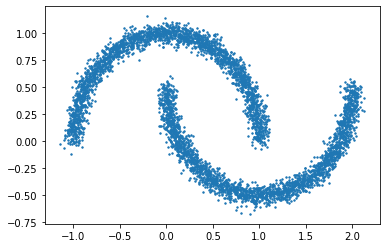

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def __call__(self, z):
        out = self.fc1(z)
        out = torch.tanh(out)
        out = self.fc2(out)
        out = torch.tanh(out)
        out = self.fc3(out)
        return out
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
    
    def __call__(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        return out

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 6.931e-01, generator: 6.748e-01


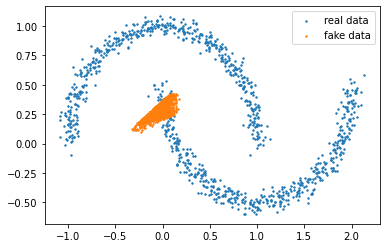

step 1000: discriminator: 6.931e-01, generator: 6.926e-01


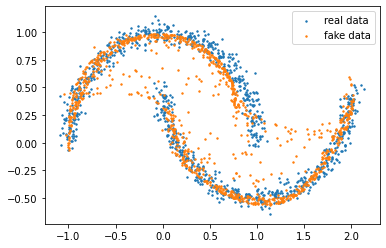

step 2000: discriminator: 6.931e-01, generator: 6.819e-01


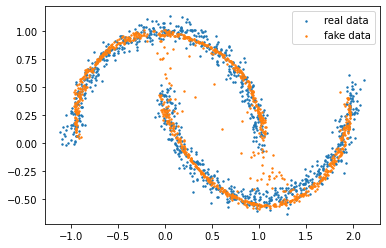

step 3000: discriminator: 6.931e-01, generator: 7.076e-01


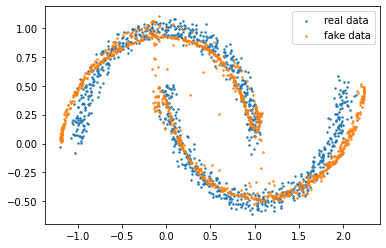

step 4000: discriminator: 6.931e-01, generator: 6.934e-01


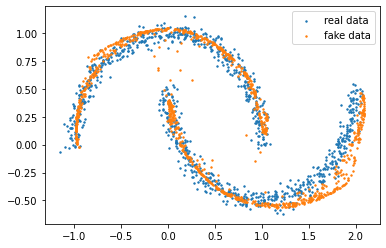

step 5000: discriminator: 6.931e-01, generator: 6.889e-01


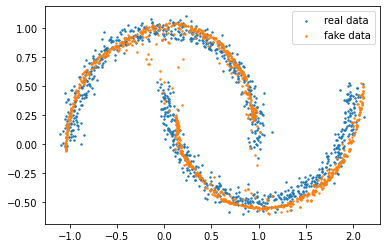

step 6000: discriminator: 6.931e-01, generator: 6.933e-01


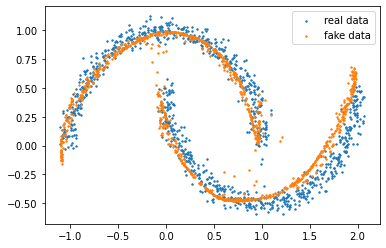

step 7000: discriminator: 6.931e-01, generator: 6.912e-01


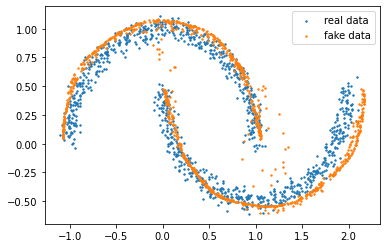

step 8000: discriminator: 6.931e-01, generator: 6.868e-01


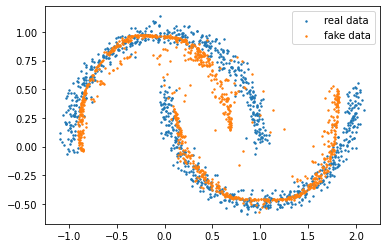

step 9000: discriminator: 6.931e-01, generator: 6.933e-01


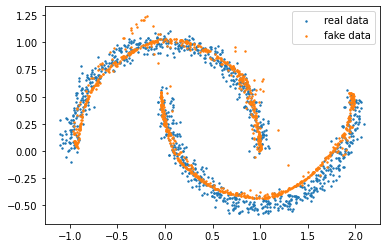

step 10000: discriminator: 6.931e-01, generator: 6.982e-01


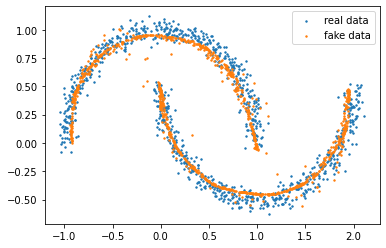

step 11000: discriminator: 6.931e-01, generator: 6.952e-01


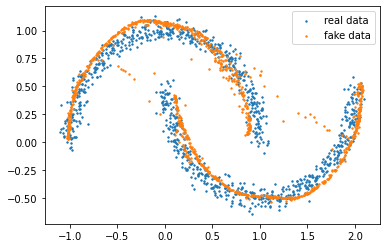

step 12000: discriminator: 6.931e-01, generator: 6.931e-01


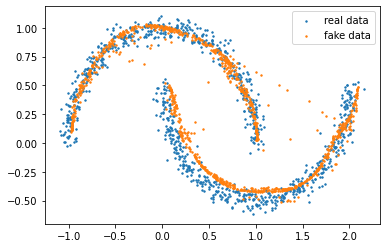

step 13000: discriminator: 6.931e-01, generator: 6.906e-01


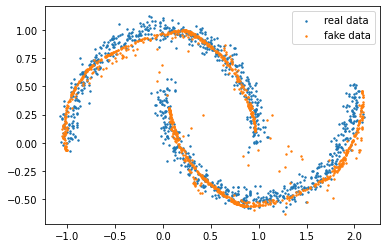

step 14000: discriminator: 6.931e-01, generator: 6.944e-01


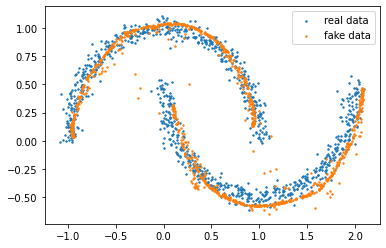

step 15000: discriminator: 6.931e-01, generator: 6.926e-01


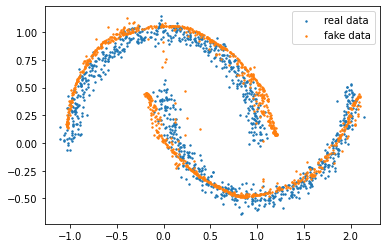

step 16000: discriminator: 6.931e-01, generator: 6.931e-01


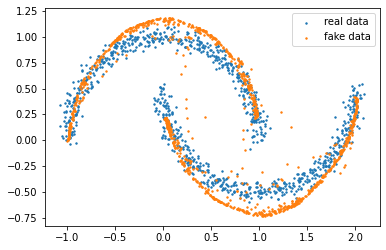

step 17000: discriminator: 6.931e-01, generator: 6.913e-01


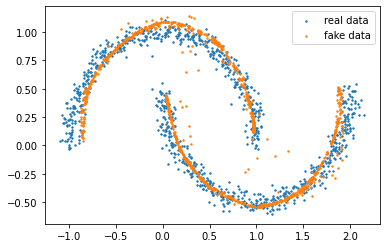

step 18000: discriminator: 6.931e-01, generator: 6.924e-01


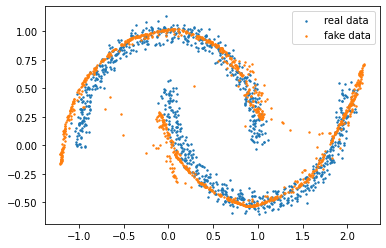

step 19000: discriminator: 6.931e-01, generator: 6.940e-01


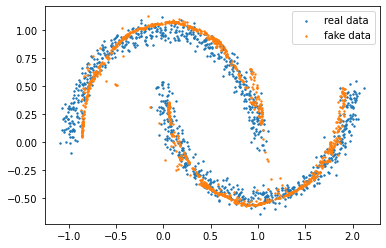

step 20000: discriminator: 6.931e-01, generator: 6.946e-01


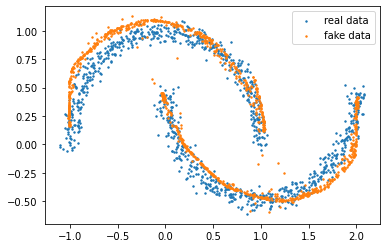

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
d_loss = nn.BCELoss()
g_loss = nn.BCELoss()

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN).detach()
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        #disc_loss = torch.mean(-torch.log(discriminator(real_batch)) - torch.log(1 - discriminator(generator(fake_batch))))
        disc_loss_real = d_loss(discriminator(real_batch), Variable(torch.ones(BATCHLEN, 1)))
        disc_loss_real.backward()
        disc_loss_fake = d_loss(discriminator(fake_batch), Variable(torch.zeros(BATCHLEN, 1)))
        disc_loss_fake.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    #gen_loss = torch.mean(torch.log(1 - discriminator(generator(fake_batch))))
    gen_loss = g_loss(discriminator(fake_batch), Variable(torch.ones(BATCHLEN, 1)))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

<font color="red">Imagine we have a really good discriminator, such that $D(G(x)) \approx 0$ for almost all $x$. Then, $\mathcal{L}_G =\mathbb{E}_{p_\theta} \log(1-D(x))$ and its gradient will be close to 0. If we change the loss to $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$, we will have much stronger gradients if the discriminator is good.</font>

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

<font color='red'>We tried different depth / width for the generator and the discriminator networks, and different values of `TRAIN_RATIO`, and here are our conclusions:</font>

*   <font color='red'>The generator has to have sufficient expressibility to be able to transform a noise to a point that looks like an original data point. In general, the wider and the deeper the network is, the better the results are and the faster the GAN converges. For example, with a three-layer network with a hidden size of 50, it converges pretty fast.
*   The point above is also true for the discriminator, which ideally has to check if a point belongs to one of the two moons. Technically, we think that the network does not have to be as deep or wide as the generator since the task is somewhat simpler, but in practice, the GAN converges faster with a wider and deeper discriminator.
*   Training with a `TRAIN_RATIO` of 5 or 10 is longer, and does not always produce better quality samples for the generator, after the same number of steps. For a value of 5, the results at the end of the training were worse than with a value of 1, but with a value of 10, the results were better after fewer steps.</font>

<font color='red'>Of course, it really depends on the initialization since the training of GANs is really unstable. Depending on the hyperparameters, two runs of the same algorithm can output totally different results.</font>



For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

<font color='red'>We have $$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right] = \mathbb{E}_{p_D}\left[log(p_D) \right] - \mathbb{E}_{p_D}\left[log(p_\theta) \right] $$ and $\mathbb{E}_{p_D}\left[log(p_D) \right]$ does not depend on $\theta$ so we directly have the equivalence.</font>

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

<font color='red'>We never sample from $p(z)$ during the training process, but we will have to sample from it to generate new data, so this might lead to unexpected results if $p$ differs from $q_{\phi}$ (even if there is a regularisation loss to ensure that there are similar).</font>

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

<font color='red'>In 1D, for $p=N(0,1)$ and $q=(\mu_q, \sigma_q)$, we have
$$\begin{align}
KL(q,p) =& -\int q(x)\log p(x) dx + \int q(x) \log q(x) dx \\
=& \frac{1}{2} \log(2\pi) + \frac{\sigma_{q}^{2} + \mu_{q}^{2}}{2} - \frac{1 + \log(2\pi \sigma_{q}^{2})}{2} \\
=& \frac{\sigma_{q}^{2} + \mu_{q}^{2} - \log(\sigma_{q}^{2}) - 1}{2}
\end{align}$$
</font>

<font color='red'>In the general N dimentional case, the result is just the sum over the components of what we previously found.</font>

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

<font color='red'>By applying the formula of the distribution of a multivariate gaussian, we directly have that
$$-\log p_\theta(x | z) = \frac{N}{2}\log(2\pi) + \sum_{i=1}^{N} \log \sigma_i + \frac{1}{2} \sum_{i=1}^{N} \frac{(x_i-\mu_i)^2}{\sigma_{i}^{2}}$$
with $\sigma_i = \sqrt{Diag(\sigma_{\theta}^{2}(z))_i}$ and $\mu_i = \mu_{\theta}(z)_i$.
 </font>

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 50

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fc1 = nn.Linear(2, 50)
        #self.fc2 = nn.Linear(50, 50)
        #self.fc3_mu = nn.Linear(50, LATENT_N)
        #self.fc3_logvar = nn.Linear(50, LATENT_N)
        self.fc1_mu = nn.Linear(2, 50)
        self.fc2_mu = nn.Linear(50, 50)
        self.fc3_mu = nn.Linear(50, LATENT_N)
        self.fc1_logvar = nn.Linear(2, 50)
        self.fc2_logvar = nn.Linear(50, 50)
        self.fc3_logvar = nn.Linear(50, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        #x = F.relu(x)
        #mu = self.fc3_mu(x)
        #logvar = self.fc3_logvar(x)
        mu = self.fc1_mu(x)
        mu = F.relu(mu)
        mu = self.fc2_mu(mu)
        mu = F.relu(mu)
        mu = self.fc3_mu(mu)
        logvar = self.fc1_logvar(x)
        logvar = F.relu(logvar)
        logvar = self.fc2_logvar(logvar)
        logvar = F.relu(logvar)
        logvar = self.fc3_logvar(logvar)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fc1 = nn.Linear(LATENT_N, 50)
        #self.fc2 = nn.Linear(50, 50)
        #self.fc3_mu = nn.Linear(50, 2)
        #self.fc3_logvar = nn.Linear(50, 2)
        self.fc1_mu = nn.Linear(LATENT_N, 50)
        self.fc2_mu = nn.Linear(50, 50)
        self.fc3_mu = nn.Linear(50, 2)
        self.fc1_logvar = nn.Linear(LATENT_N, 50)
        self.fc2_logvar = nn.Linear(50, 50)
        self.fc3_logvar = nn.Linear(50, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        #z = self.fc1(z)
        #z = F.relu(z)
        #z = self.fc2(z)
        #z = F.relu(z)
        #mu = self.fc3_mu(z)
        #logvar = self.fc3_logvar(z)
        mu = self.fc1_mu(z)
        mu = F.relu(mu)
        mu = self.fc2_mu(mu)
        mu = F.relu(mu)
        mu = self.fc3_mu(mu)
        logvar = self.fc1_logvar(z)
        logvar = F.relu(logvar)
        logvar = self.fc2_logvar(logvar)
        logvar = F.relu(logvar)
        logvar = self.fc3_logvar(logvar)
        #hard_enc = 10**(-4)
        #logvar = torch.zeros_like(mu) + np.log(hard_enc**2)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.037e+02, rec: 9.798e+01


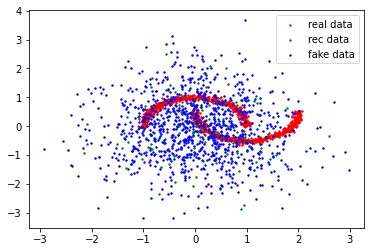

step 1000: KL: 3.068e+01, rec: -1.934e+01


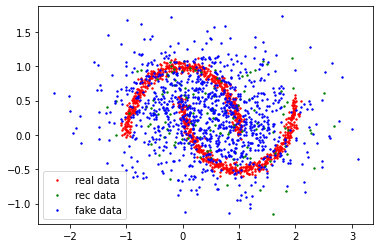

step 2000: KL: 1.311e+02, rec: -1.443e+02


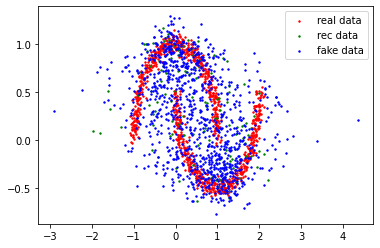

step 3000: KL: 1.598e+02, rec: -1.823e+02


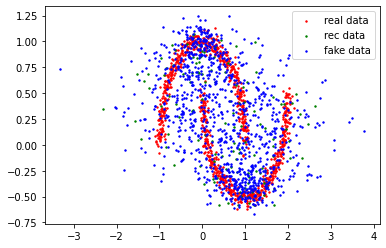

step 4000: KL: 1.724e+02, rec: -1.812e+02


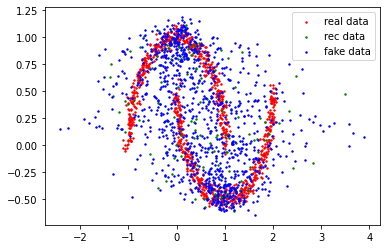

step 5000: KL: 1.713e+02, rec: -2.158e+02


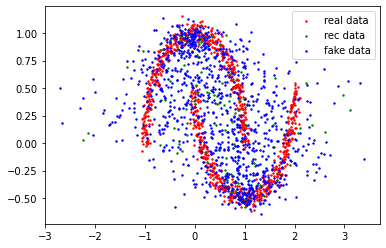

step 6000: KL: 1.743e+02, rec: -2.047e+02


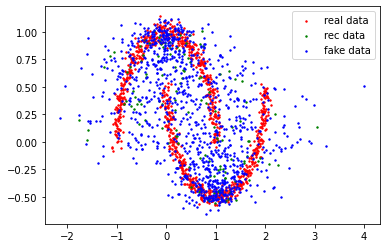

step 7000: KL: 1.868e+02, rec: -2.294e+02


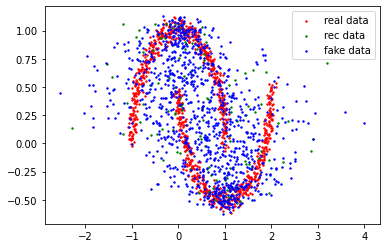

step 8000: KL: 1.832e+02, rec: -2.110e+02


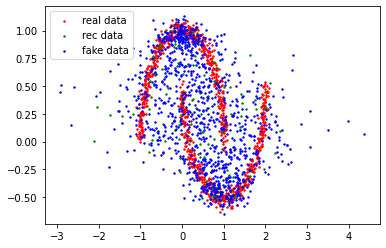

step 9000: KL: 1.846e+02, rec: -2.042e+02


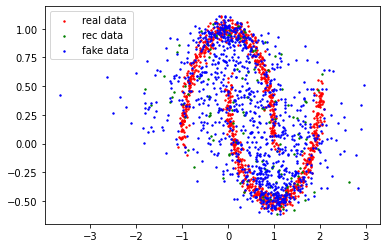

step 10000: KL: 1.915e+02, rec: -2.329e+02


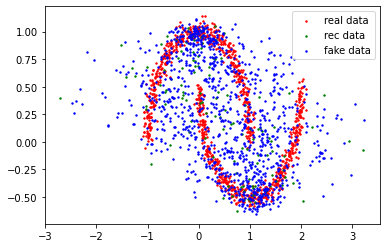

step 11000: KL: 1.968e+02, rec: -2.439e+02


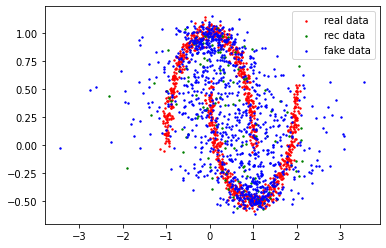

step 12000: KL: 2.035e+02, rec: -2.512e+02


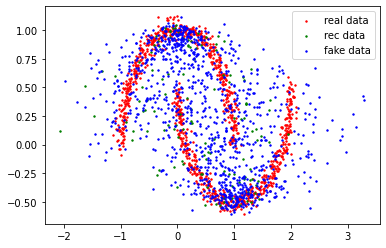

step 13000: KL: 1.988e+02, rec: -2.277e+02


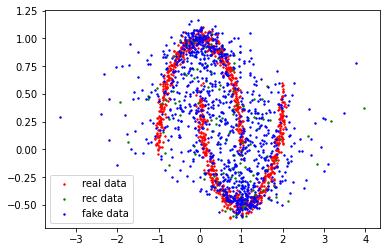

step 14000: KL: 2.054e+02, rec: -2.405e+02


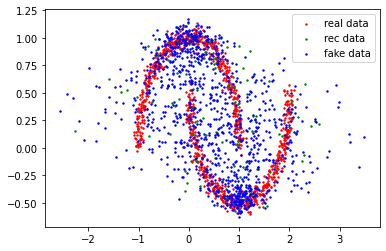

step 15000: KL: 2.005e+02, rec: -2.531e+02


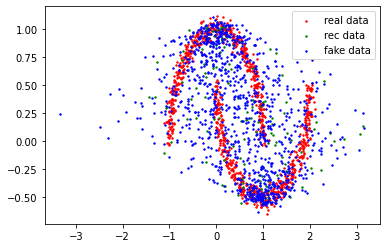

step 16000: KL: 2.023e+02, rec: -2.478e+02


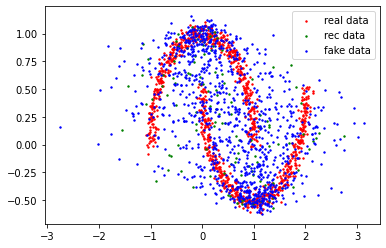

step 17000: KL: 1.971e+02, rec: -2.367e+02


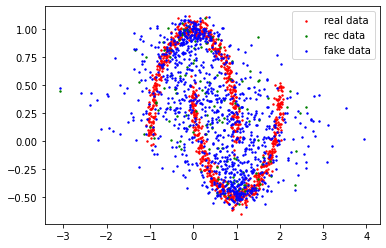

step 18000: KL: 2.014e+02, rec: -2.453e+02


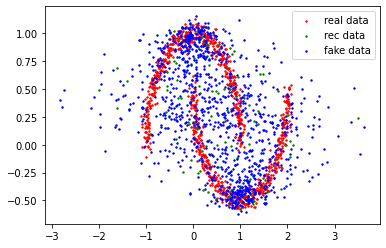

step 19000: KL: 2.064e+02, rec: -2.614e+02


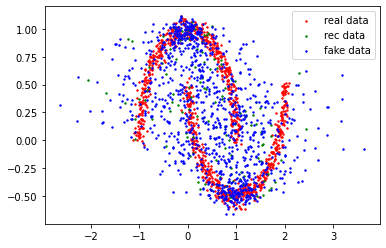

step 20000: KL: 2.133e+02, rec: -2.543e+02


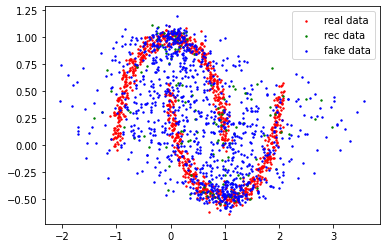

step 21000: KL: 2.195e+02, rec: -2.722e+02


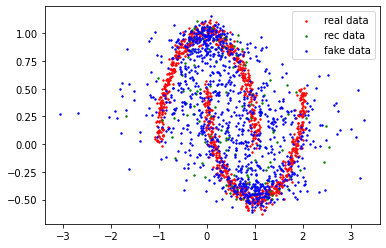

step 22000: KL: 2.113e+02, rec: -2.575e+02


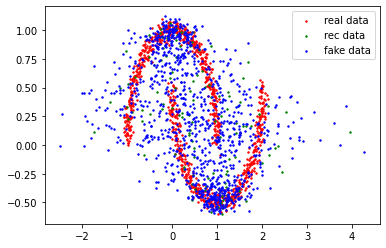

step 23000: KL: 2.142e+02, rec: -2.529e+02


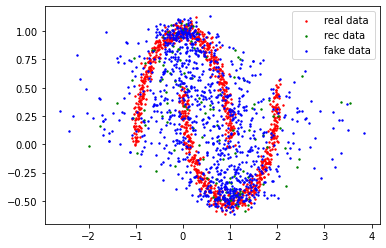

step 24000: KL: 2.055e+02, rec: -2.617e+02


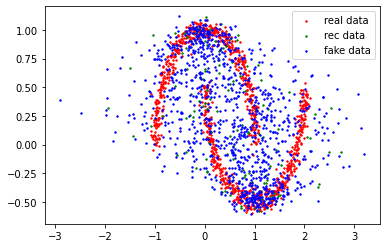

step 25000: KL: 2.142e+02, rec: -2.638e+02


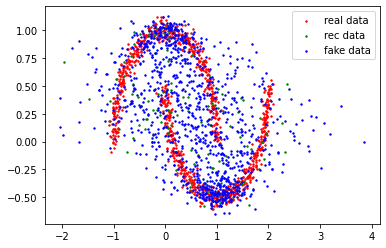

step 26000: KL: 2.186e+02, rec: -2.700e+02


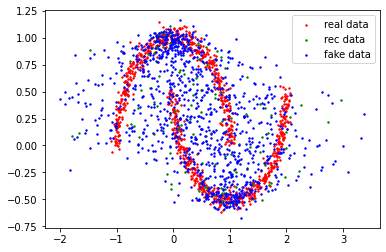

step 27000: KL: 2.109e+02, rec: -2.672e+02


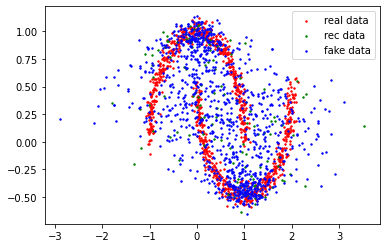

step 28000: KL: 2.123e+02, rec: -2.613e+02


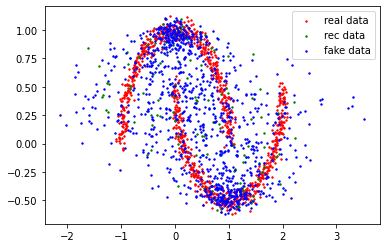

step 29000: KL: 2.188e+02, rec: -2.862e+02


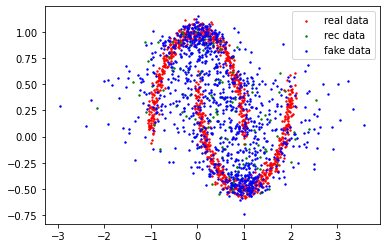

step 30000: KL: 2.195e+02, rec: -2.603e+02


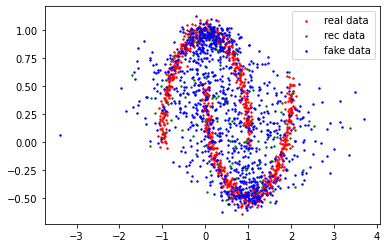

step 31000: KL: 2.187e+02, rec: -2.689e+02


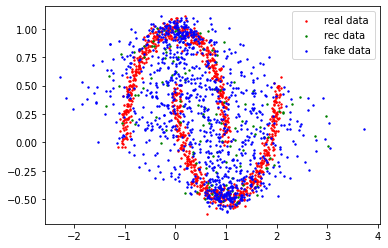

step 32000: KL: 2.178e+02, rec: -2.517e+02


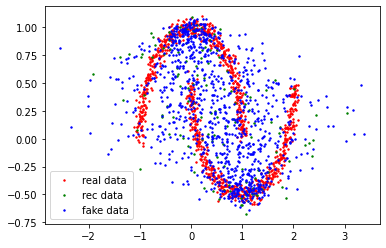

step 33000: KL: 2.129e+02, rec: -2.581e+02


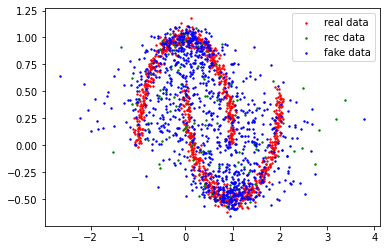

step 34000: KL: 2.287e+02, rec: -2.857e+02


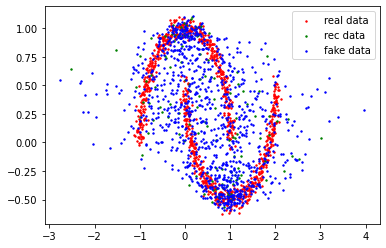

step 35000: KL: 2.222e+02, rec: -2.729e+02


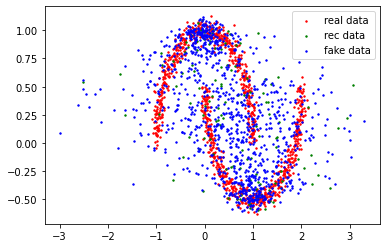

step 36000: KL: 2.290e+02, rec: -2.729e+02


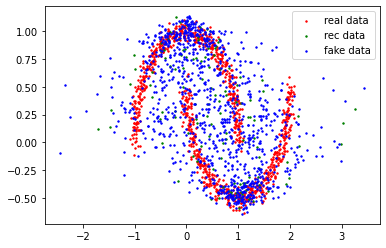

step 37000: KL: 2.211e+02, rec: -2.602e+02


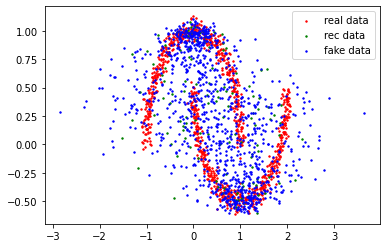

step 38000: KL: 2.312e+02, rec: -2.841e+02


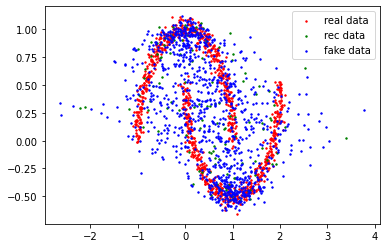

step 39000: KL: 2.188e+02, rec: -2.762e+02


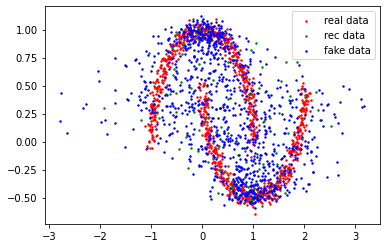

step 40000: KL: 2.202e+02, rec: -2.689e+02


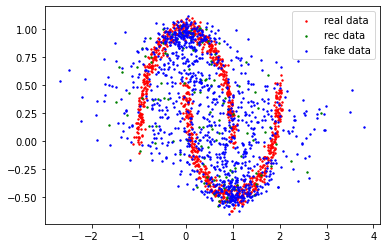

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum(torch.exp(enc_logvar) + enc_mu.pow(2) - enc_logvar - 1)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = torch.randn_like(enc_mu).mul(torch.exp(0.5 * enc_logvar)).add_(enc_mu)
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = torch.sum(0.5 * dec_logvar + 0.5 * torch.div((x - dec_mu).pow(2),torch.exp(dec_logvar)))
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data', c='r')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data', c='g')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data', c='b')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

<font color='red'>We tried to hardcode $\sigma_{\theta}(z)$ by fixing it to 1E-4. We obtained generated fake data that looked like one ball in the center of the two moons. It is less accurate than when we do not hardcode it.</font>

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

<font color='red'>We are not sure to understand this question, but if it was about how the training is affected when we have wider and deeper networks for the encoder and the decoder, then it usually results in better quality generated fake data from our experiments.</font>

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

<font color='red'>The "changement de variable" formula (see the section "Cas des intégrales multiples" on Wikipedia [here](https://fr.wikipedia.org/wiki/Int%C3%A9gration_par_changement_de_variable)) is valid for every open set $U$ and every function $f$ ($f$ denoting the function in the Wikipedia formula, not the mapping from $p_D$). Therefore, the quantities inside the integrals on the left and right of the equation are equal for $z=f(x)$ (if we take our notations). We then just have to take the $\log$ to find the above equality.</font>

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

<font color='red'>We have
\begin{align}
KL(p_D||p_G) &= \int_{x} p_D \log(\frac{p_D}{p_G}) dx \\
&= Cst -  \int_{x} p_D \log(p_G) dx \\
&= Cst - \mathbb{E}_{x\sim p_D}[\log(p_G(x))] \\
& \approx Cst - \frac{1}{N} \sum_{i=1}^{N} \log(p_G(x_i))
\end{align}
</font>

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

<font color='red'>If we denote $x_1 = x_{1:d}$, $y_1 = y_{1:d}$, $x_2 = x_{d+1:D}$ and $y_2 = y_{d+1:D}$, we have that
$$
\left\{
    \begin{array}{ll}
        y_1 & = x_1 \\
        y_2 & = x_2 \odot \exp(s(x_1)) + t(x_1)
    \end{array}
\right.
$$
Therefore, the defined mapping is invertible and the inverse is
$$
\left\{
    \begin{array}{ll}
        x_1 & = y_1 \\
        x_2 & = \frac{y_2 - t(y_1)}{\exp(s(y_1))}
    \end{array}
\right.
$$
where the division is made component-wise.

And the composition of invertible functions is also invertible.
</font>

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

<font color='red'>The Jacobian matrix of the mapping is a lower triangular matrix. The determinant is then the product of the values in the diagonal.</font>

<font color='red'>The first $d$ values in the diagonal are $1$, and the $D-d$ following are $\exp(s(x_{1:d})_j)$ for $1 \leq j \leq D-d$. </font>

<font color='red'>Thus, the final determinant is $\exp(\sum_j s(x_{1:d})_j)$.
</font>

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.fc1_s = nn.Linear(input_size, hidden_size)
        self.fc2_s = nn.Linear(hidden_size, hidden_size)
        self.fc3_s = nn.Linear(hidden_size, hidden_size)
        self.fc4_s = nn.Linear(hidden_size, output_size)

        self.fc1_t = nn.Linear(input_size, hidden_size)
        self.fc2_t = nn.Linear(hidden_size, hidden_size)
        self.fc3_t = nn.Linear(hidden_size, hidden_size)
        self.fc4_t = nn.Linear(hidden_size, output_size)
        
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.fc1_s(x_m)
        x_m = torch.tanh(x_m)
        x_m = self.fc2_s(x_m)
        x_m = torch.tanh(x_m)
        x_m = self.fc3_s(x_m)
        x_m = torch.tanh(x_m)
        x_m = self.fc4_s(x_m)
        x_m = torch.tanh(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.fc1_t(x_m)
        x_m = F.relu(x_m)
        x_m = self.fc2_t(x_m)
        x_m = F.relu(x_m)
        x_m = self.fc3_t(x_m)
        x_m = F.relu(x_m)
        x_m = self.fc4_t(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        s_out = self.sfun(y)
        t_out = self.tfun(y)
        x = y * self.mask + (1-self.mask) * torch.div((y - t_out), torch.exp(s_out))
        return x

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 128
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.021193
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.038320
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.046840
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.048880
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.049490
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.051115
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.052839
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055062
====> Epoch: 1 Average train loss: -0.0456


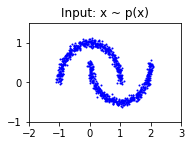

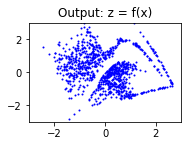

====> Test loss: -0.0559


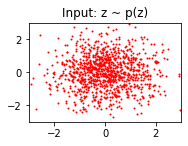

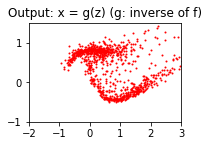

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.054235
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.055452
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.055025
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.056996
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.056776
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.056539
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.055876
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058076
====> Epoch: 2 Average train loss: -0.0565


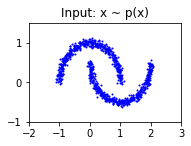

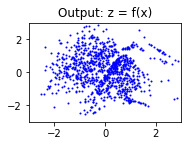

====> Test loss: -0.0585


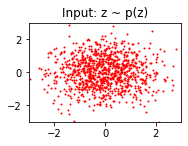

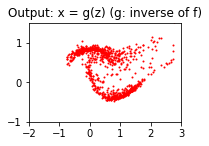

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.057804
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.057280
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058150
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.056823
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.057472
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.056960
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.058420
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.059084
====> Epoch: 3 Average train loss: -0.0577


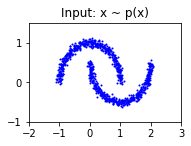

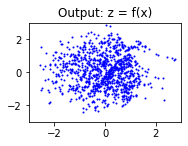

====> Test loss: -0.0597


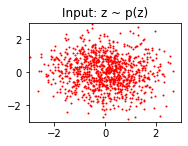

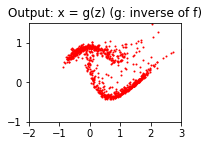

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.057699
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.057608
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058524
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.057788
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.058975
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059430
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.058546
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.058446
====> Epoch: 4 Average train loss: -0.0587


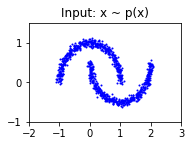

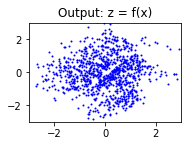

====> Test loss: -0.0600


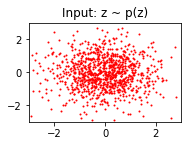

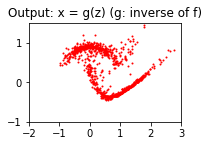

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.058196
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059801
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059239
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058897
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.058850
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.058275
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.057560
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.058892
====> Epoch: 5 Average train loss: -0.0591


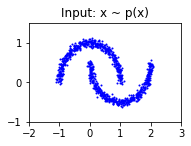

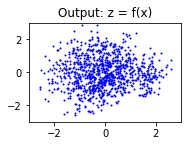

====> Test loss: -0.0606


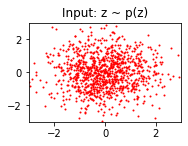

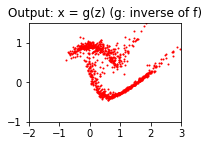

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059435
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059690
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.058570
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059147
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059149
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.057804
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.060088
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059975
====> Epoch: 6 Average train loss: -0.0593


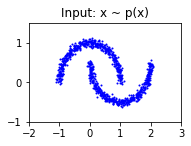

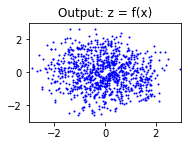

====> Test loss: -0.0608


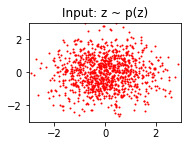

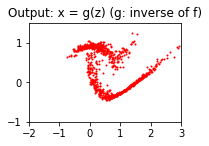

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.058442
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058950
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059839
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.058812
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059870
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059726
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059156
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.058524
====> Epoch: 7 Average train loss: -0.0593


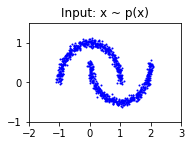

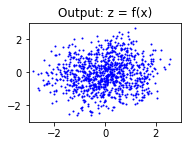

====> Test loss: -0.0609


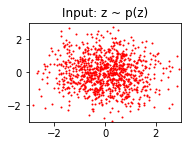

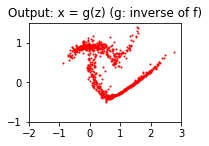

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059596
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059688
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.058653
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.058662
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059898
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059752
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059872
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059583
====> Epoch: 8 Average train loss: -0.0595


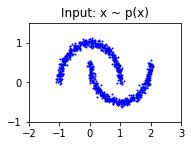

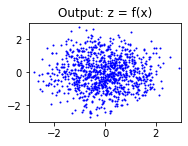

====> Test loss: -0.0610


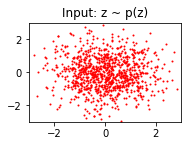

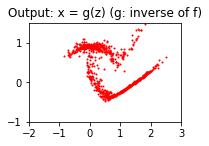

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059332
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.058230
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.060093
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.058515
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.060434
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058837
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.060148
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059448
====> Epoch: 9 Average train loss: -0.0595


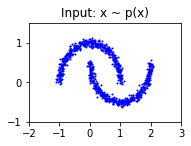

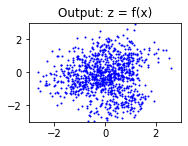

====> Test loss: -0.0603


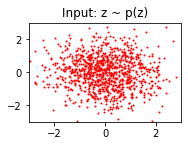

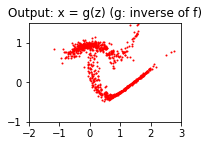

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.057640
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058796
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059707
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060045
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059665
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059525
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059806
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.060741
====> Epoch: 10 Average train loss: -0.0595


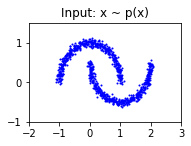

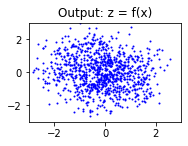

====> Test loss: -0.0609


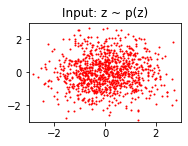

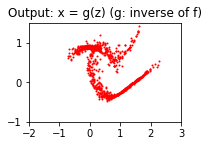

'160.19s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

<font color='red'>Normalizing flows is harder when there are many clusters in data because the function $f$ has to map all of these clusters to one that should be distributed as a gaussian.

A weighted sum of gaussians is also gaussian, so if we have $N$ clusters in data, $f$ could try to map each of these clusters to a gaussian (in practice we don't know exactly what's going on because $f$ is a complex function), making thus the problem $N$ times harder.</font>

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

<font color='red'>**GANs:** GANs are able to produce in practice the closest result to the true distribution. The presence of a discriminator really helps the optimization process by continuously giving feedback to the generator. However, their training is quite unstable, but there are solutions to try to improve on this point (WGAN for example).</font>

<font color='red'>**VAEs:** VAEs are still performant on image generation tasks, but less than GANs. Sampling has a more important part in the training, so VAEs should be better at creating new points that are similar as the training examples, but not simply copies of them. VAEs are also better at compressing data.</font>

<font color='red'>**Normalizing flows:** Normalizing flows are worse than GANs and VAEs in terms of quality of the learned distribution. But one advantage is that this is the only method that really outputs a probability for a generated sample, which can be useful is some situations.</font>